In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np

from kernel import KernelComputer, KernelRegressor
from ranking import BasicFasSolver, IlpSolver, AC, IL, SP
from dataloader import Synthesizer
from ranking.fassolver.embedding import get_sym_embs

In [2]:
%matplotlib inline
np.random.seed(0)

In [3]:
import numba


@numba.jit("(f8[:, :], f8[:, :], i8[:, :])", nopython=True)
def fill_distance(dist, y_score, ind_map):
    m = len(ind_map)
    for j in range(m):
        for i in range(j):
            ind = ind_map[i, j]
            dist[:,ind] = y_score[i] - y_score[j]

## Toy problem

Let's imagine a toy problem, where we have to order $m$ linear forms over $X = \mathbb{R}$

In [4]:
m = 4
n_test = 200

datagen = Synthesizer('RK-' + str(m))
x_test, (y_test, y_score) = datagen.get_testset(n_test, verbose=True)

In [5]:
ind_map = datagen.loader.ind_map

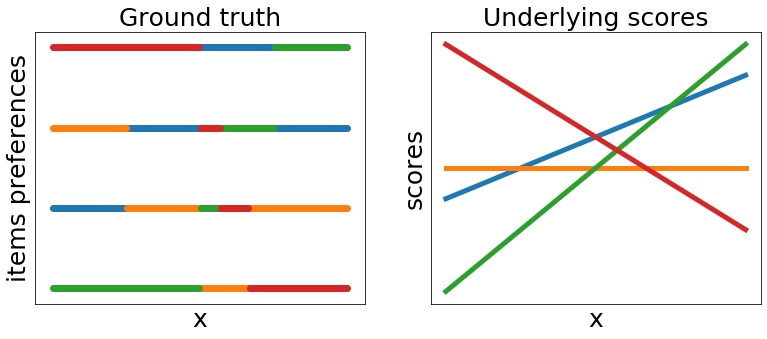

In [6]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13,5))
y = get_sym_embs(y_test, ind_map).sum(axis=-1).argsort()
for i in range(y.shape[1]):
    ax1.scatter(x_test, (y == i).argmax(axis=1))
    ax2.plot(x_test, y_score[i], linewidth=5)
ax1.set_title('Ground truth', size=25)
ax1.set_ylabel('items preferences', size=25)
ax2.set_title('Underlying scores', size=25)
ax2.set_ylabel('scores', size=25)
for ax in [ax1, ax2]:
    ax.set_xlabel("x", size=25)
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)
fig.savefig('ranking_setting.pdf')

In [7]:
nb_folds = 8
corruptions = np.linspace(.5, 1, num=8)
sigmas = [1e0, 5e-1]
lambdas = [1e3, 1e0, 1e-3]

n_train = 50
n_test = 200

In [8]:
kernel = KernelComputer('Gaussian', sigma=1)
kernel_reg = KernelRegressor(kernel)

In [9]:
m = 10
datagen = Synthesizer('RK-' + str(m))
ind_map = datagen.loader.ind_map

solver = IlpSolver(ind_map)
solver.choose_solver_method('primal')
solver.shut_up()

# solver = BasicFasSolver(ind_map)

msolver = IlpSolver(ind_map)
msolver.choose_solver_method('dual')
msolver.shut_up()

met_ac = AC(kernel_reg.kernel, solver)
met_il = IL(kernel_reg.kernel, solver)

In [10]:
shape_err = (len(corruptions), nb_folds, len(sigmas), len(lambdas))

err_ac = -np.ones(shape_err)
err_il = -np.ones(shape_err)

for fold in range(nb_folds):
    datagen = Synthesizer('RK-' + str(m))
    x_train, (y_train, y_score) = datagen.get_trainset(n_train, verbose=True)
    x_test, y_test = datagen.get_trainset(n_test)
    kernel_reg.set_support(x_train[:, np.newaxis])
    n_train, dim = x_train[:, np.newaxis].shape    

    for i_s, c_sigma in enumerate(sigmas):
        sigma = c_sigma * dim
        kernel_reg.update_sigma(sigma)

        for i_l, c_lambda in enumerate(lambdas):
            lambd = c_lambda / np.sqrt(n_train)
            kernel_reg.update_lambda(lambd)

            for i_c, corruption in enumerate(corruptions):
                S_train = y_train.copy()
                
                dist = np.empty(S_train.shape)
                fill_distance(dist, y_score, datagen.loader.ind_map)
                np.abs(dist, out=dist)
                dist /= np.max(dist, axis=1)[:, np.newaxis]
#                 dist **= 2
                ind_lost = dist > 1 - corruption
                S_train[ind_lost] = 0
                
#                 S_train[np.random.rand(*S_train.shape) < corruption] = 0

                met_ac.train(None, S_train, None, num=100, K_inv=-kernel_reg.K_inv)
                met_il.train(None, S_train, None, K_inv=-kernel_reg.K_inv)

                y_ac = met_ac(x_test[:, np.newaxis], verbose=False)
                y_il = met_il(x_test[:, np.newaxis], solver=msolver, verbose=False)
            
                err_ac[i_c, fold, i_s, i_l] = ((2*(y_ac > 0) - 1) != y_test).mean()
                err_il[i_c, fold, i_s, i_l] = ((2*(y_il > 0) - 1) != y_test).mean()
                print((corruption * 10) // 1, end=',')

5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.0,7.0,7.0,8.0,9.0,10.0,5.0,5.0,6.

In [11]:
mus = np.empty((3, len(corruptions)))
stds = np.empty((3, len(corruptions)))

for err, i in zip([err_ac, err_il], [0, 1]):
    tmp = err.reshape(err.shape[0], err.shape[1], -1)
    mu = tmp.mean(axis=1)
    std = tmp.std(axis=1)
    ind = mu.argmin(axis=-1)
    for j in range(len(ind)):
        mus[i, j] = mu[j, ind[j]]
        stds[i, j] = std[j, ind[j]]

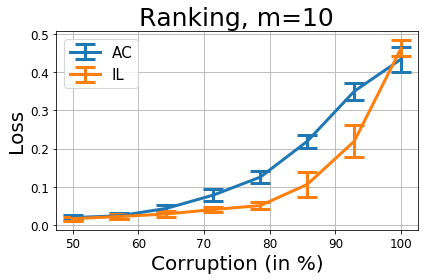

In [12]:
fig, ax = plt.subplots()
a = ax.errorbar([100*i for i in corruptions[:]], mus[0][:], .5*stds[0][:], capsize=10, linewidth=3, capthick=3)
b = ax.errorbar([100*i for i in corruptions[:]], mus[1][:], .5*stds[1][:], capsize=10, linewidth=3, capthick=3)
ax.legend([a, b], ['AC', "IL"], prop={'size':15})
ax.grid()
ax.set_title('Ranking, m=10', size=25)
ax.set_ylabel('Loss', size=20)
ax.set_xlabel('Corruption (in %)', size=20)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
fig.savefig('RK-10.pdf')

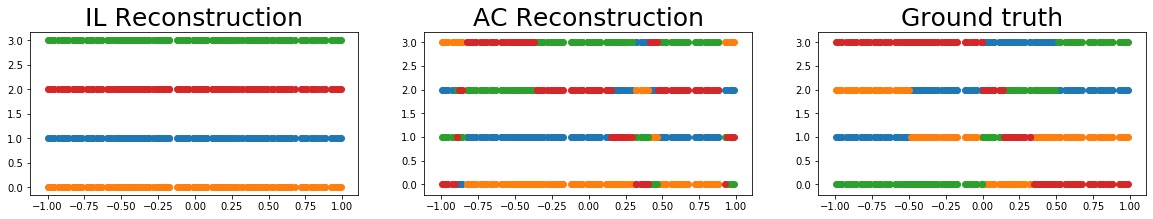

In [13]:
def show_reconstruction(x_test, y_ac, y_il, y_test, ind_map):
    m = len(ind_map)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 3))

    s_ac = get_sym_embs(y_ac, ind_map).sum(axis=1).argsort()[:,::-1]
    s_il = get_sym_embs(y_il, ind_map).sum(axis=1).argsort()[:,::-1]
#     s_sp = get_sym_embs(y_sp, ind_map).sum(axis=1).argsort()[:,::-1]
    s_t = get_sym_embs(y_test, ind_map).sum(axis=1).argsort()[:,::-1]
    for i in range(m):
        ax2.scatter(x_test, (s_ac==i).argmax(axis=1))
        ax1.scatter(x_test, (s_il==i).argmax(axis=1))
#         ax3.scatter(x_test, (s_sp==i).argmax(axis=1))
        ax3.scatter(x_test, (s_t==i).argmax(axis=1))

    ax2.set_title("AC Reconstruction", size=25)
    ax1.set_title("IL Reconstruction", size=25)
#     ax3.set_title("SP Reconstruction", size=25)
    ax3.set_title("Ground truth", size=25)
    fig.savefig('ranking_reconstruction.pdf')
    
    
show_reconstruction(x_test, y_ac, y_il, y_test, ind_map)